In [1]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Marginal

## Build dataset

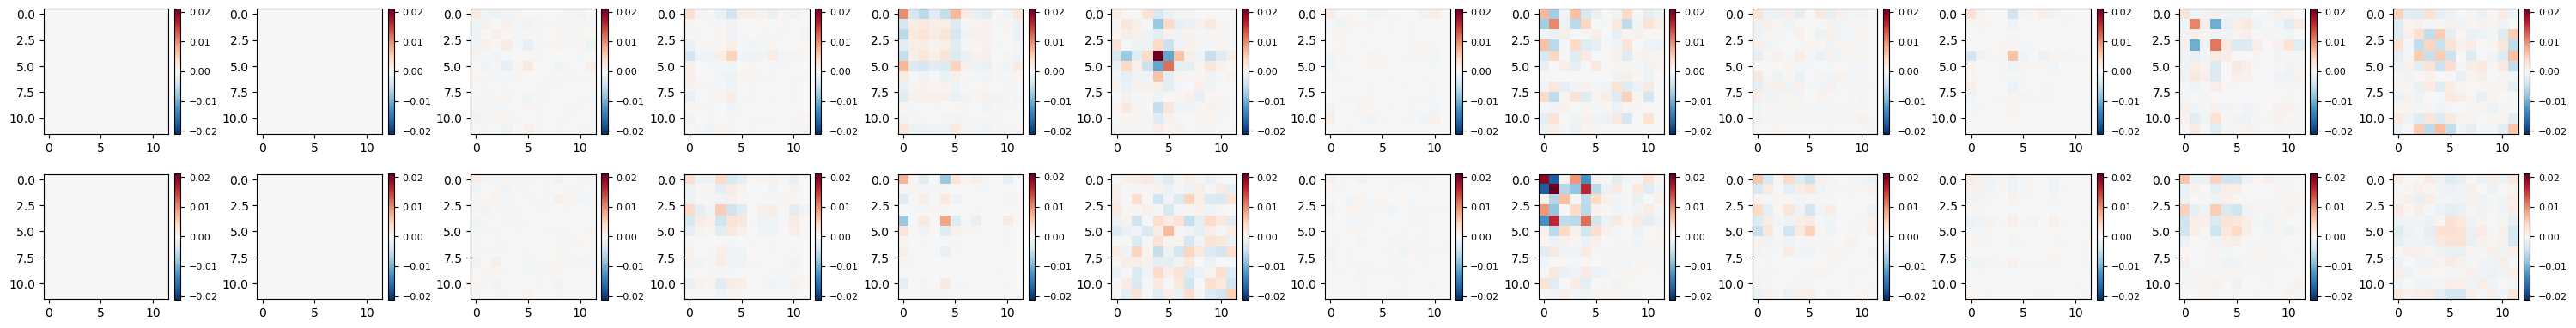

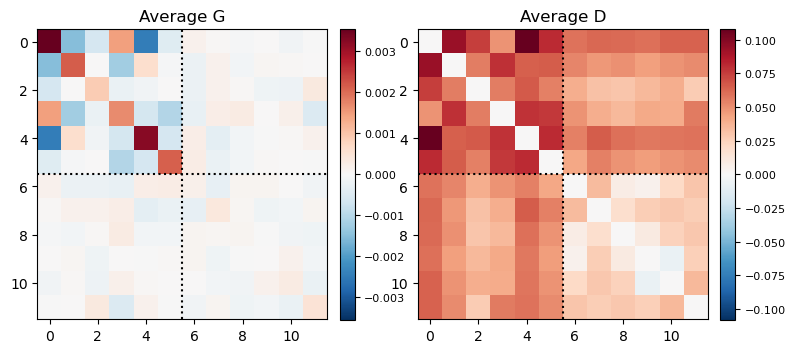

In [4]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
sn_bad = [102, 103]

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

hem = ['L', 'R']
data, cond_vec, part_vec = [], [], []
for i_hem, h in enumerate(hem):
    roi = f'{region}_{h}'
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]
    
    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]
    
    for i_sub in range(len(subject)):
        Y = []
        subj_part = []
        subj_cond = []

        # lhand marginal:
        for cond_num, direction in enumerate(labels):
            # in each partition:
            for k in range(1,11):
                # bimanual trials that left hand goes in that direction:
                tmp_name = f'bi:{direction}_'
                idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                idx = idx1 & idx2
                y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
            subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
            condition_name = f'lhand:{direction}'
            # find the condition numbers corresponding to this condition:
            idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
            subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

        # rhand marginal:
        for cond_num, direction in enumerate(labels):
            # in each partition:
            for k in range(1,11):
                # bimanual trials that right hand goes in that direction:
                tmp_name = f'_{direction}'
                idx1 = np.array([tmp.endswith(tmp_name) for tmp in cond_name_tmp[i_sub]])
                idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                idx = idx1 & idx2
                y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
            subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
            condition_name = f'rhand:{direction}'
            # find the condition numbers corresponding to this condition:
            idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
            subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

        subj_cond = np.array(subj_cond)
        # Sort based on Hemisphere to have contralateral first:
        if h == 'L':
            tmp = subj_cond.copy()
            subj_cond[tmp > 5] = tmp[tmp > 5] - 6
            subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 

        data.append(Y)
        cond_vec.append(subj_cond)
        part_vec.append(subj_part)

Y = []
# --- Build dataset ---
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

# --- RDM Calculation ---
N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(2,12,figsize=(30,4))
vmax = np.abs(G_hat).max()
for i in range(N):
    ax[i//12,i%12].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//12,i%12], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

# avg:
fig, ax = plt.subplots(1,2,figsize=(9,4))
G_hat_avg = np.mean(G_hat, axis=0)
vmax = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')
ax[0].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[0].axvline(5.5, color='k', linestyle=':', linewidth=1.5)

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')
ax[1].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[1].axvline(5.5, color='k', linestyle=':', linewidth=1.5)
plt.show() 




## Build models

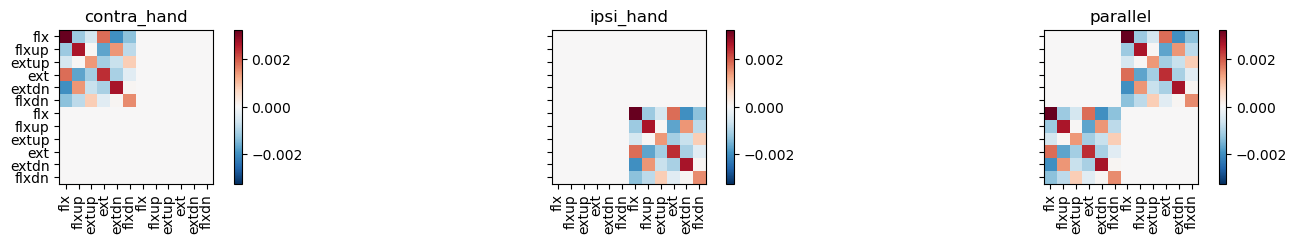

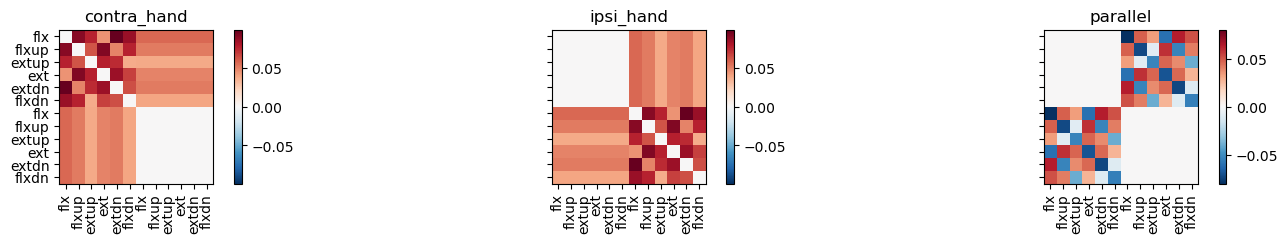

In [5]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12

M = []
modelG = {}

# Null model
cov = np.zeros((ncond, ncond))
M.append(pcm.FixedModel('null', cov))

# Contra hand structure:
ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
ceil = pcm.FreeModel('ceil',6)
params = ceil_fit['theta_cv'][0]
params = np.mean(params[0:21, :], axis=1)
G_ceil = ceil.predict(params)[0]
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_ceil
modelG['contra_hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_ceil
modelG['ipsi_hand'] = [cov]

# Parallel contra-ipsi:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = G_ceil
cov[6:12, 0:6] = G_ceil
modelG['parallel'] = [cov]

# component models:
M.append(pcm.ComponentModel('contra', [modelG['contra_hand'][0]]))
M.append(pcm.ComponentModel('ipsi', [modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('contra+ipsi', [modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('parallel', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))

# PLOT:
n = len(modelG)
fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    vmin = -np.max(np.abs(modelG[list(modelG.keys())[i]]))
    vmax = np.max(np.abs(modelG[list(modelG.keys())[i]]))
    ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    D = pcm.G_to_dist(modelG[list(modelG.keys())[i]][0])
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()




## Fit model

In [ ]:
import pickle

# fit model:
T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)

results = {
            'T_gr': T_gr, 'theta_gr': theta_gr,
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
with open(os.path.join(analysisDir, f'PCM_marginal_{region}.pkl'), 'wb') as f:
    pickle.dump(results, f)




## Fit all regions

In [23]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
sn_bad = [102, 103]

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    # =============================== BUILD DATASET ===============================
    hem = ['L', 'R']
    data, cond_vec, part_vec = [], [], []
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]
        
        for i_sub in range(len(subject)):
            Y = []
            subj_part = []
            subj_cond = []

            # lhand marginal:
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that left hand goes in that direction:
                    tmp_name = f'bi:{direction}_'
                    idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'lhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            # rhand marginal:
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that right hand goes in that direction:
                    tmp_name = f'_{direction}'
                    idx1 = np.array([tmp.endswith(tmp_name) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'rhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            subj_cond = np.array(subj_cond)
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 

            data.append(Y)
            cond_vec.append(subj_cond)
            part_vec.append(subj_part)

    Y = []
    # --- Build dataset ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # ============================== BUILD MODELS ==============================
    labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
    labels_lateral = ['contra']*6 + ['ipsi']*6
    ncond = 12

    M = []
    modelG = {}

    # Null model
    cov = np.zeros((ncond, ncond))
    M.append(pcm.FixedModel('null', cov))

    # Contra hand structure:
    ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
    ceil = pcm.FreeModel('ceil',6)
    params = ceil_fit['theta_cv'][0]
    params = np.mean(params[0:21, :], axis=1)
    G_ceil = ceil.predict(params)[0]
    cov = np.zeros((ncond, ncond))
    cov[0:6, 0:6] = G_ceil
    modelG['contra_hand'] = [cov]

    # Ipsi hand structure:
    cov = np.zeros((ncond, ncond))
    cov[6:12, 6:12] = G_ceil
    modelG['ipsi_hand'] = [cov]

    # Parallel contra-ipsi:
    cov = np.zeros((ncond, ncond))
    cov[0:6, 6:12] = G_ceil
    cov[6:12, 0:6] = G_ceil
    modelG['parallel'] = [cov]

    # component models:
    M.append(pcm.ComponentModel('contra', [modelG['contra_hand'][0]]))
    M.append(pcm.ComponentModel('ipsi', [modelG['ipsi_hand'][0]]))
    M.append(pcm.ComponentModel('contra+ipsi', [modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
    M.append(pcm.ComponentModel('parallel', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))

    # noise ceiling:
    M.append(pcm.FreeModel('ceil',ncond))
    
    # =============================== FIT MODEL ===============================
    T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)

    results = {
                'T_gr': T_gr, 'theta_gr': theta_gr,
                'T_cv': T_cv, 'theta_cv': theta_cv
                }
    with open(os.path.join(analysisDir, f'PCM_marginal_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)




Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group model 0
Fitting group model 1
Fitting group model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)


Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)


Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group model 0
Fitting group model 1
Fitting group model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: overflow encountered in multiply
  Gs = G * exp(scale_param)


Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: overflow encountered in multiply
  Gs = G * exp(scale_param)


Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group model 0
Fitting group model 1
Fitting group model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)


Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)


Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group model 0
Fitting group model 1
Fitting group model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)


Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)


Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group model 0
Fitting group model 1
Fitting group model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)


Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:175: RuntimeWarning: overflow encountered in exp
  exp_theta=np.reshape(np.exp(theta),(theta.size,1,1)) # Bring into the right shape for broadcasting
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/model.py:176: RuntimeWarning: invalid value encountered in multiply
  dG_dTheta = self.Gc * exp_theta  # This is also the derivative dexp(x)/dx = exp(x)
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:73: RuntimeWarning: invalid value encountered in multiply
  Gs = G * exp(scale_param)


Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


## Plot

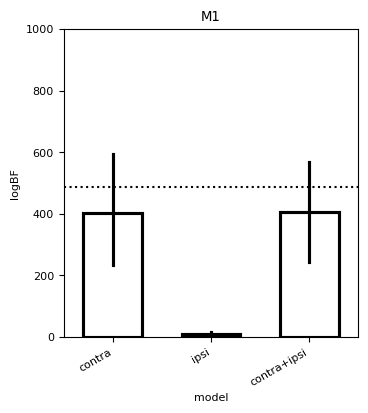

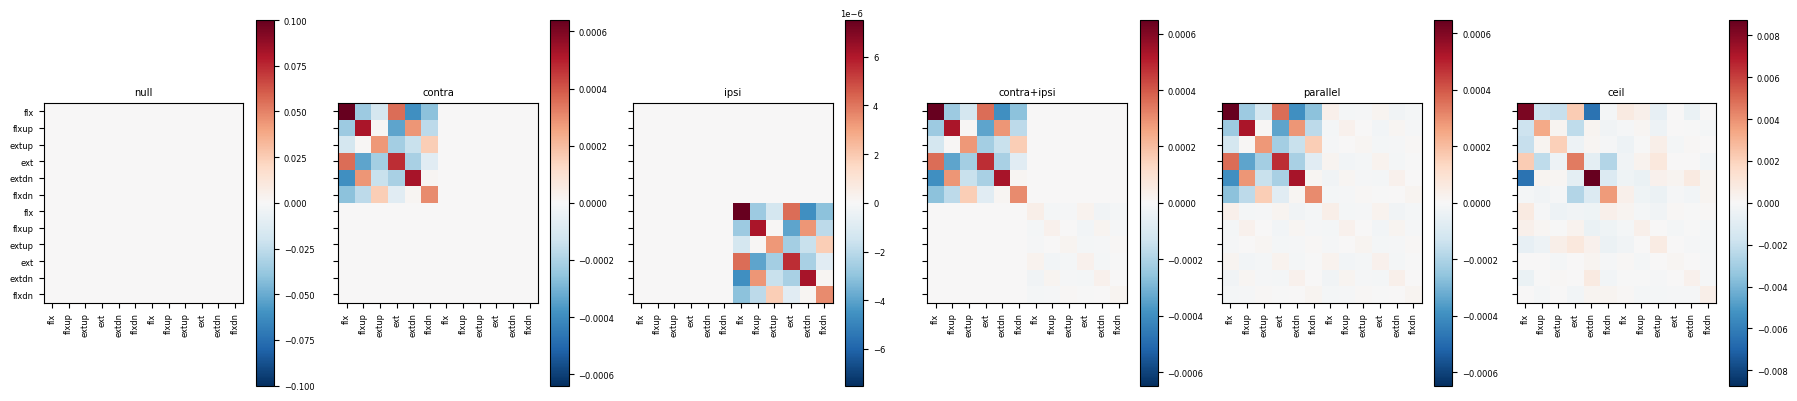

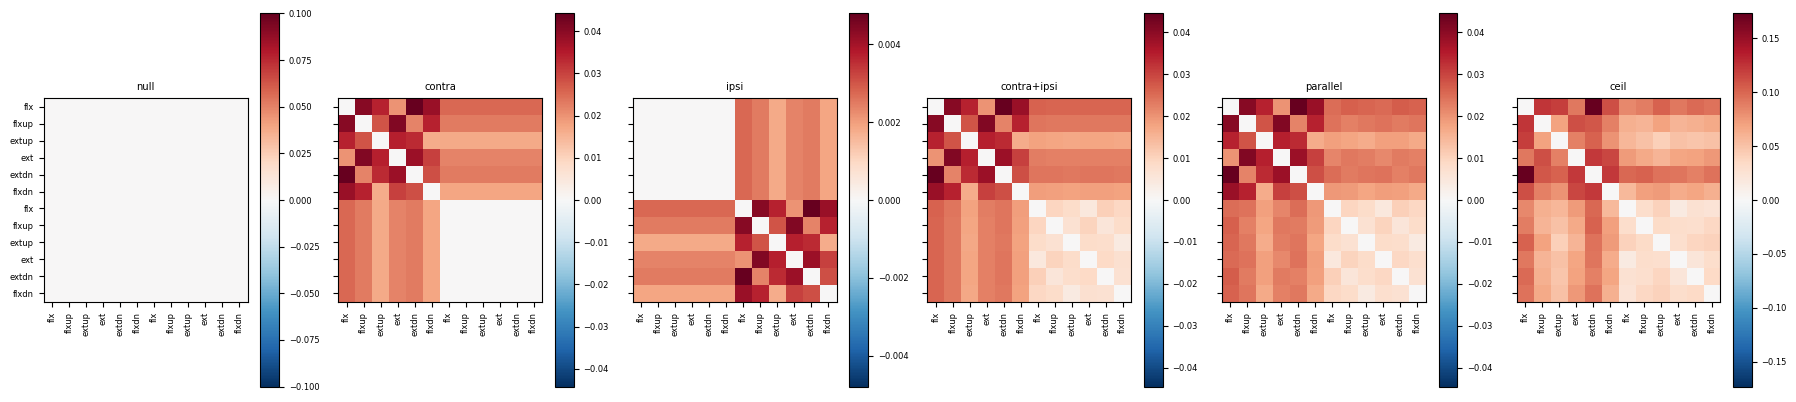

In [79]:
# load model fits:
import pickle
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']

# load model fitting:
with open(os.path.join(analysisDir, f'PCM_marginal_{region}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)
T_cv = results['T_cv']
theta_cv = results['theta_cv']

# =============================== BUILD MODELS ===============================
ncond = 12
M = []
modelG = {}

# Null model
cov = np.zeros((ncond, ncond))
M.append(pcm.FixedModel('null', cov))

# Contra hand structure:
ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
ceil = pcm.FreeModel('ceil',6)
params = ceil_fit['theta_cv'][0]
params = np.mean(params[0:21, :], axis=1)
G_ceil = ceil.predict(params)[0]
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_ceil
modelG['contra_hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_ceil
modelG['ipsi_hand'] = [cov]

# Parallel contra-ipsi:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = G_ceil
cov[6:12, 0:6] = G_ceil
modelG['parallel'] = [cov]

# component models:
M.append(pcm.ComponentModel('contra', [modelG['contra_hand'][0]]))
M.append(pcm.ComponentModel('ipsi', [modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('contra+ipsi', [modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('parallel', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))
M.append(pcm.FreeModel('ceil',ncond))

# =============================== PLOT ===============================
cmap = 'RdBu_r'
max_range = 1000

# set font:
matplotlib.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1,1,figsize=(3.8,4))
likelihood = T_cv.likelihood
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)
likelihood = likelihood.loc[:, (likelihood.columns == 'contra') | (likelihood.columns == 'ipsi') | (likelihood.columns == 'contra+ipsi') | (likelihood.columns == 'ceil')]
LL = likelihood.melt(var_name='model', value_name='logBF')
ceil = LL[LL['model'] == 'ceil']['logBF'].values
sns.barplot(data=LL[LL['model'] != 'ceil'], x='model', y='logBF', ax=ax, fill=False, color='k', width=0.6)
ax.axhline(np.mean(ceil), color='k', linestyle=':', linewidth=1.5)
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
ax.set_ylim((0, max_range))
plt.show()

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()




## t-test

In [21]:
# load model fits:
import pickle

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
for region in regions:
    print(f'\n======================= processing {region} =======================')
    # load model fitting:
    with open(os.path.join(analysisDir, f'PCM_marginal_{region}.pkl'), 'rb') as f:
        results = pickle.load(f)

    T_gr = results['T_gr']
    theta_gr = results['theta_gr']
    nmodels = len(theta_gr)
    T_cv = results['T_cv']
    theta_cv = results['theta_cv']

    # T-test between models:
    from scipy import stats
    likelihood = T_cv.likelihood
    m_names = likelihood.columns.values
    baseline = likelihood.loc[:,'null'].values
    likelihood = likelihood - baseline.reshape(-1,1)

    bayesfact = {'contra': [], 'ipsi': [], 'contra+ipsi': [], 'parallel': []}
    bayesfact['contra'] = likelihood['contra'].values
    bayesfact['ipsi'] = likelihood['ipsi'].values
    bayesfact['contra+ipsi'] = likelihood['contra+ipsi'].values
    bayesfact['parallel'] = likelihood['parallel'].values

    # ttest each model > 0:
    ttests = {}
    for k in bayesfact.keys():
        t, p = stats.ttest_1samp(bayesfact[k], 0, alternative='greater')
        mean = np.mean(bayesfact[k])
        std = np.std(bayesfact[k])
        sem = stats.sem(bayesfact[k])
        ttests[k] = {'t': t, 'p': p, 'dof': len(bayesfact[k])-1, 'mean': mean, 'std': std, 'sem': sem}
        print(f'{k}: t({ttests[k]["dof"]})={t:.2f}, p={p:.4f}, mean={mean:.2f} std={std:.2f} sem={sem:.2f}')

    # Model comparisons:
    t, p = stats.ttest_rel(bayesfact['contra+ipsi'], bayesfact['contra'], alternative='greater')
    mean_diff = np.mean(bayesfact['contra+ipsi'] - bayesfact['contra'])
    std_diff = np.std(bayesfact['contra+ipsi'] - bayesfact['contra'])
    sem_diff = stats.sem(bayesfact['contra+ipsi'] - bayesfact['contra'])
    dof = len(bayesfact['contra+ipsi']) - 1
    print('\nModel comparison:')
    print(f'contra+ipsi > contra: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')






======================= processing M1 =======================
contra: t(23)=4.50, p=0.0001, mean=404.17 std=430.95 sem=89.86
ipsi: t(23)=2.27, p=0.0165, mean=8.83 std=18.67 sem=3.89
contra+ipsi: t(23)=4.57, p=0.0001, mean=405.09 std=424.88 sem=88.59
parallel: t(23)=4.57, p=0.0001, mean=405.35 std=425.67 sem=88.76

Model comparison:
contra+ipsi > contra: t(23)=0.39, p=0.3513, mean_diff=0.92 std_diff=11.45 sem_diff=2.39

======================= processing S1 =======================
contra: t(23)=6.68, p=0.0000, mean=3049.60 std=2189.80 sem=456.60
ipsi: t(23)=10.28, p=0.0000, mean=493.07 std=230.12 sem=47.98
contra+ipsi: t(23)=8.05, p=0.0000, mean=3576.25 std=2129.93 sem=444.12
parallel: t(23)=8.02, p=0.0000, mean=3588.56 std=2144.65 sem=447.19

Model comparison:
contra+ipsi > contra: t(23)=10.13, p=0.0000, mean_diff=526.65 std_diff=249.32 sem_diff=51.99

======================= processing PMd =======================
contra: t(23)=10.14, p=0.0000, mean=1777.24 std=840.66 sem=175.29
ipsi:

# Bimanual

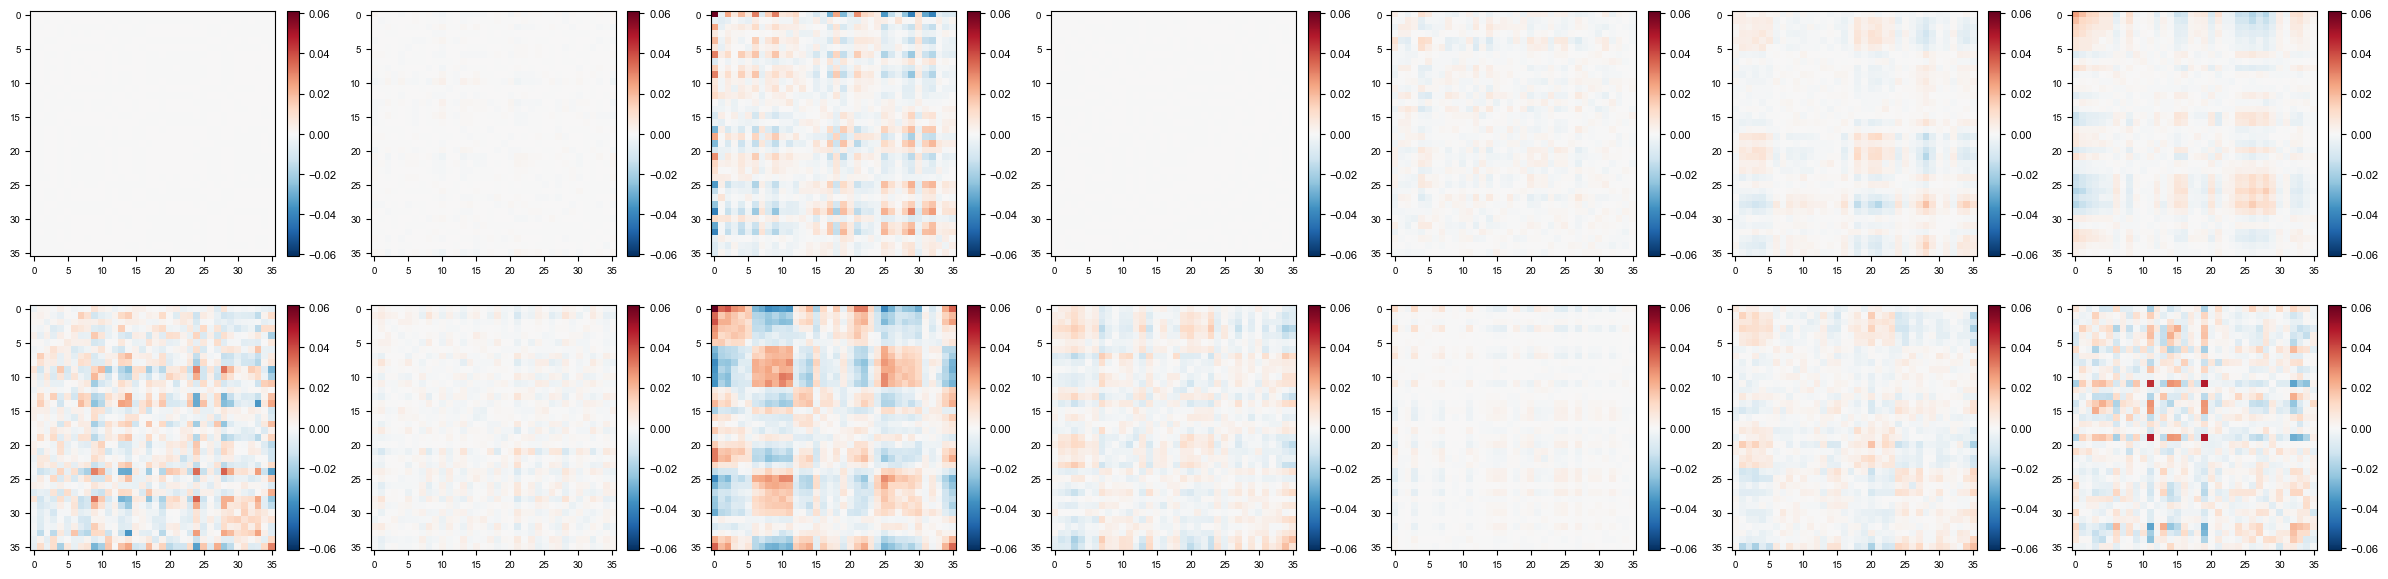

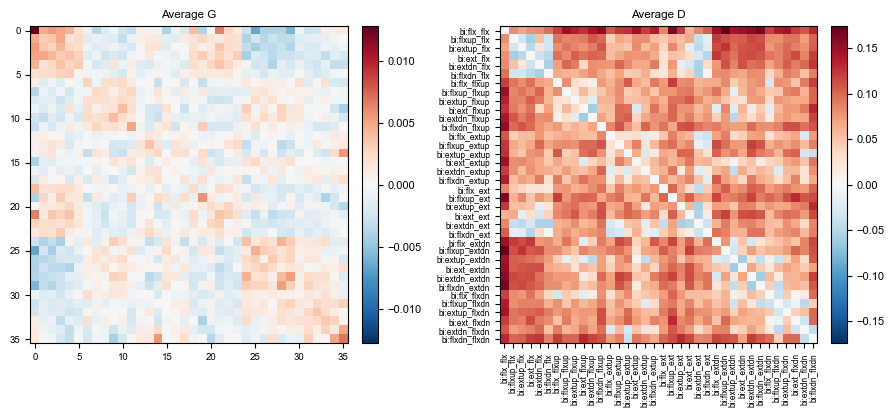

In [152]:
labels = {'L': ['bi:flx_flx', 'bi:flxup_flx', 'bi:extup_flx', 'bi:ext_flx', 'bi:extdn_flx', 'bi:flxdn_flx', 
                'bi:flx_flxup', 'bi:flxup_flxup', 'bi:extup_flxup', 'bi:ext_flxup', 'bi:extdn_flxup', 'bi:flxdn_flxup', 
                'bi:flx_extup', 'bi:flxup_extup', 'bi:extup_extup', 'bi:ext_extup', 'bi:extdn_extup', 'bi:flxdn_extup', 
                'bi:flx_ext', 'bi:flxup_ext', 'bi:extup_ext', 'bi:ext_ext', 'bi:extdn_ext', 'bi:flxdn_ext', 
                'bi:flx_extdn', 'bi:flxup_extdn', 'bi:extup_extdn', 'bi:ext_extdn', 'bi:extdn_extdn', 'bi:flxdn_extdn', 
                'bi:flx_flxdn', 'bi:flxup_flxdn', 'bi:extup_flxdn', 'bi:ext_flxdn', 'bi:extdn_flxdn', 'bi:flxdn_flxdn' ],

          'R': ['bi:flx_flx',    'bi:flx_flxup',   'bi:flx_extup',   'bi:flx_ext',   'bi:flx_extdn',   'bi:flx_flxdn',
                'bi:flxup_flx',  'bi:flxup_flxup', 'bi:flxup_extup', 'bi:flxup_ext', 'bi:flxup_extdn', 'bi:flxup_flxdn',
                'bi:extup_flx',  'bi:extup_flxup', 'bi:extup_extup', 'bi:extup_ext', 'bi:extup_extdnn', 'bi:extup_flxdn',
                'bi:ext_flx',    'bi:ext_flxup',   'bi:ext_extup',   'bi:ext_ext',   'bi:ext_extdn',   'bi:ext_flxdn',
                'bi:extdn_flx',  'bi:extdn_flxup', 'bi:extdn_extup', 'bi:extdn_ext', 'bi:extdn_extdn', 'bi:extdn_flxdn',
                'bi:flxdn_flx',  'bi:flxdn_flxup', 'bi:flxdn_extup', 'bi:flxdn_ext', 'bi:flxdn_extdn', 'bi:flxdn_flxdn']
}

cmap = 'RdBu_r'
sn_bad = []

condition = 'bi'
region = 'M1'
hem = 'R'
regions = [f'{region}_{hem}']

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7

for roi in regions:
    # enumerate hemispheres so we get an integer index for axes
    data, cond_vec, part_vec = [], [], []
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]

    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    if '_R' in roi:
        cond_vec_tmp = d['cond_num_vec'][indices]
    elif '_L' in roi:
        cond_vec_tmp = d['cond_num_lhem_bimanual_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]

    for i_sub in range(len(subject)):
        # Filter for the current condition
        idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'bi' in c]
        Y = data_tmp[i_sub][idx, :]
        subj_cond = cond_vec_tmp[i_sub][idx]
        subj_part = part_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
        
N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(2*len(regions),7,figsize=(30,7))
vmax = np.abs(G_hat).max()
for i in range(N):
    ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# avg:
fig, ax = plt.subplots(1,2,figsize=(9,4))
G_hat_avg = np.mean(G_hat, axis=0)
# G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
vmax = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')
ax[1].set_xticks(list(range(ncond)))
ax[1].set_yticks(list(range(ncond)))
ax[1].set_yticklabels(labels['L'], fontsize=6)
ax[1].set_xticklabels(labels['L'], rotation=90, fontsize=6)
plt.tight_layout()
plt.show() 



## Models

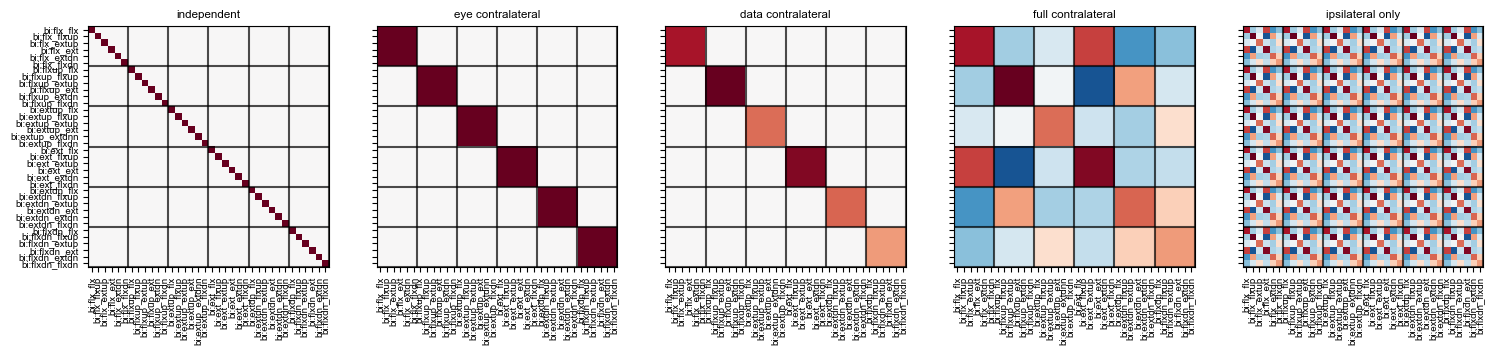

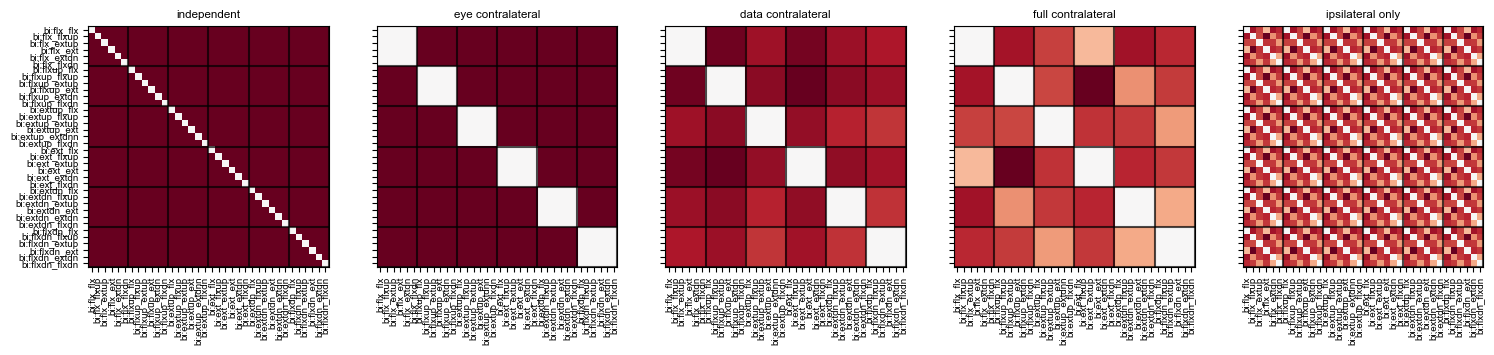

In [156]:
# load unimanual data representations:
uni_contra = pd.read_pickle(os.path.join(analysisDir, 'RDMs_uni_contra.pkl'))
uni_ipsi = pd.read_pickle(os.path.join(analysisDir, 'RDMs_uni_ipsi.pkl'))
G_uni = uni_contra[uni_contra.region == region].G.values[0]/2 + uni_ipsi[uni_ipsi.region == region].G.values[0]/2
G_bi = pd.read_pickle(os.path.join(analysisDir, 'RDMs_bi.pkl'))

ncond = 36

M = []
modelG = []

# Independent Hand Model:
cov = np.eye(ncond)
cov = cov/np.trace(cov)
M.append(pcm.model.FixedModel('independent', cov))

# Independent Contralateral Hand Model:
cov = np.eye(6)
cov = np.kron(cov, np.ones((6, 6)))
cov = cov/np.trace(cov)
M.append(pcm.model.FixedModel('eye contralateral', cov))

# Data Contralateral Hand Model:
cov = G_uni * np.eye(6)
cov = np.kron(cov, np.ones((6, 6)))
cov = cov/np.trace(cov)
M.append(pcm.model.FixedModel('data contralateral', cov))

# Full Contralateral hand model:
cov = np.kron(G_uni, np.ones((6, 6)))
cov = cov/np.trace(cov)
modelG.append(cov)
M.append(pcm.model.FixedModel('full contralateral', cov))

# Ipsilateral only model:
cov = np.tile(G_uni, (6,6))
cov = cov/np.trace(cov)
modelG.append(cov)
M.append(pcm.model.FixedModel('ipsilateral only', cov))

# Full Linear Contra + Ipsi model:
M_full = pcm.ComponentModel('fullcontra+ipsi',[modelG[0],modelG[1]])
M.append(M_full)

# ceiling:
# M_ceil = pcm.model.FreeModel('ceil',ncond) # TAKES TOO LONG TO FIT
M_ceil = pcm.model.FixedModel('ceil', G_bi)
M.append(M_ceil)

# ================== Visualize Models ==================
nmodels = len(M)
fix, ax = plt.subplots(1,nmodels-2, figsize=(18,4), sharey=True)
for i in range(nmodels-2):
    vmin = -np.max(np.abs(M[i].G))-1e-6
    vmax = np.max(np.abs(M[i].G))+1e-6
    ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax)
    block = 6
    bounds = [i * block - 0.5 for i in range(ncond // block + 1)]
    for b in bounds:
        ax[i].axhline(b, color='k', lw=1.5, alpha=0.7)
        ax[i].axvline(b, color='k', lw=1.5, alpha=0.7)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(ncond)))
    ax[i].set_xticklabels(labels[hem], rotation=90)
    ax[i].set_yticks(list(range(ncond)))
    ax[i].set_yticklabels(labels[hem])
    # plt.colorbar(ax[i].imshow(M[i].G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1,nmodels-2, figsize=(18,4), sharey=True)
for i in range(nmodels-2):
    D = pcm.G_to_dist(M[i].G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D)) - 1e-6
    vmax = np.max(np.abs(D)) + 1e-6
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    block = 6
    bounds = [i * block - 0.5 for i in range(ncond // block + 1)]
    for b in bounds:
        ax[i].axhline(b, color='k', lw=1.5, alpha=0.7)
        ax[i].axvline(b, color='k', lw=1.5, alpha=0.7)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(ncond)))
    ax[i].set_xticklabels(labels[hem], rotation=90)
    ax[i].set_yticks(list(range(ncond)))
    ax[i].set_yticklabels(labels[hem])
    # plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()



## Fit model

In [ ]:
T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

# save the results:
import pickle
results = {
           'T_gr': T_gr, 'theta_gr': theta_gr,
           'T_cv': T_cv, 'theta_cv': theta_cv
           }
with open(os.path.join(analysisDir, f'PCM_bimanual_{region}.pkl'), 'wb') as f:
    pickle.dump(results, f)

fig, ax = plt.subplots(1,1, figsize=(20,3))
ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil',
                        upper_ceiling = T_gr.likelihood['ceil'])
# ax.set_ylim(-300, 150)
plt.title(f'{region}')
plt.show()



## all together:

Fitting CV M1_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


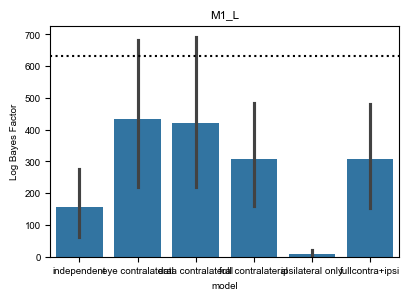

Fitting CV M1_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


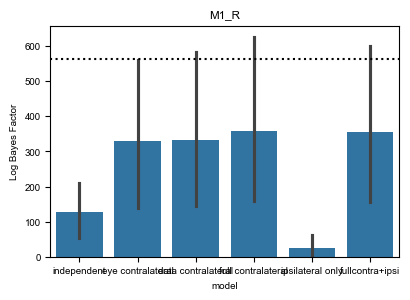

Fitting CV S1_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


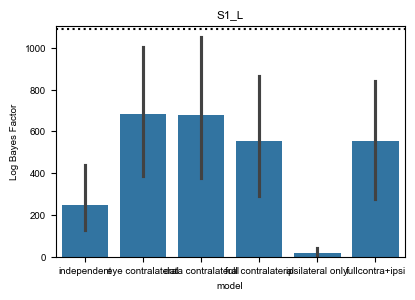

Fitting CV S1_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


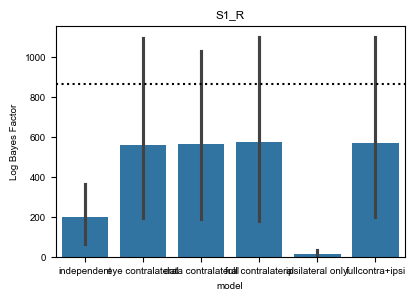

Fitting CV PMd_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


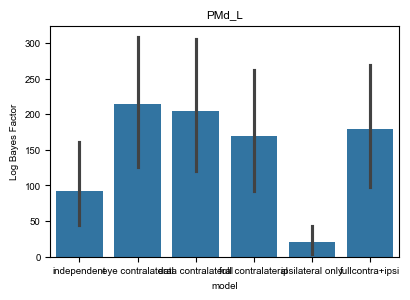

Fitting CV PMd_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


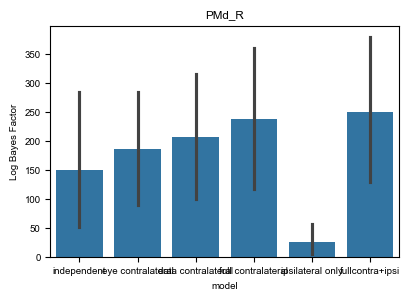

Fitting CV PMv_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


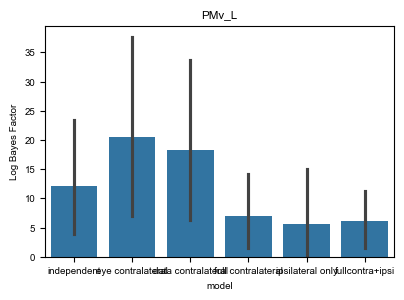

Fitting CV PMv_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


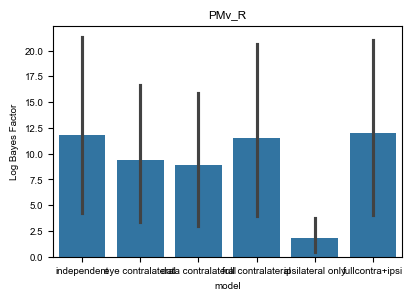

Fitting CV SMA_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


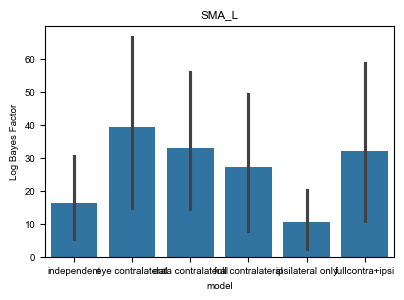

Fitting CV SMA_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


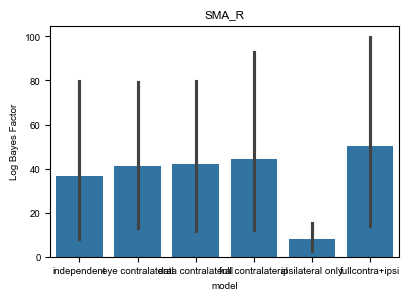

Fitting CV SPLa_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


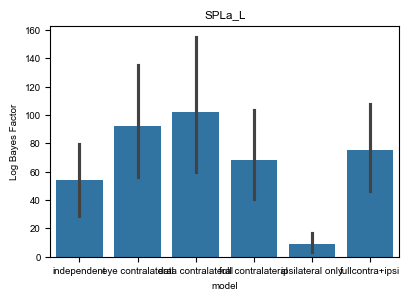

Fitting CV SPLa_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


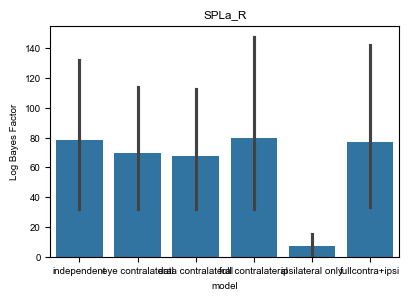

Fitting CV SPLp_L ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


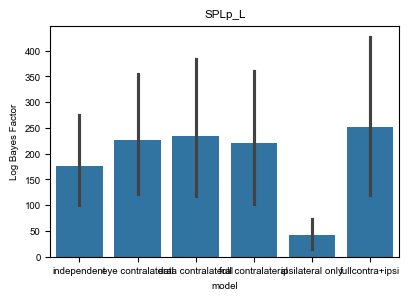

Fitting CV SPLp_R ...
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


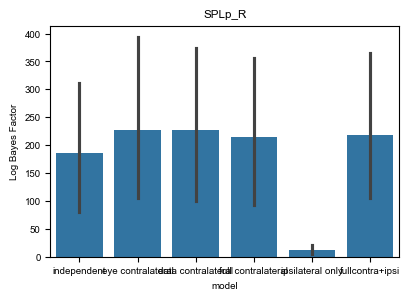

In [ ]:
labels = {'L': ['bi:flx_flx', 'bi:flxup_flx', 'bi:extup_flx', 'bi:ext_flx', 'bi:extdn_flx', 'bi:flxdn_flx', 
                'bi:flx_flxup', 'bi:flxup_flxup', 'bi:extup_flxup', 'bi:ext_flxup', 'bi:extdn_flxup', 'bi:flxdn_flxup', 
                'bi:flx_extup', 'bi:flxup_extup', 'bi:extup_extup', 'bi:ext_extup', 'bi:extdn_extup', 'bi:flxdn_extup', 
                'bi:flx_ext', 'bi:flxup_ext', 'bi:extup_ext', 'bi:ext_ext', 'bi:extdn_ext', 'bi:flxdn_ext', 
                'bi:flx_extdn', 'bi:flxup_extdn', 'bi:extup_extdn', 'bi:ext_extdn', 'bi:extdn_extdn', 'bi:flxdn_extdn', 
                'bi:flx_flxdn', 'bi:flxup_flxdn', 'bi:extup_flxdn', 'bi:ext_flxdn', 'bi:extdn_flxdn', 'bi:flxdn_flxdn' ],

          'R': ['bi:flx_flx',    'bi:flx_flxup',   'bi:flx_extup',   'bi:flx_ext',   'bi:flx_extdn',   'bi:flx_flxdn',
                'bi:flxup_flx',  'bi:flxup_flxup', 'bi:flxup_extup', 'bi:flxup_ext', 'bi:flxup_extdn', 'bi:flxup_flxdn',
                'bi:extup_flx',  'bi:extup_flxup', 'bi:extup_extup', 'bi:extup_ext', 'bi:extup_extdnn', 'bi:extup_flxdn',
                'bi:ext_flx',    'bi:ext_flxup',   'bi:ext_extup',   'bi:ext_ext',   'bi:ext_extdn',   'bi:ext_flxdn',
                'bi:extdn_flx',  'bi:extdn_flxup', 'bi:extdn_extup', 'bi:extdn_ext', 'bi:extdn_extdn', 'bi:extdn_flxdn',
                'bi:flxdn_flx',  'bi:flxdn_flxup', 'bi:flxdn_extup', 'bi:flxdn_ext', 'bi:flxdn_extdn', 'bi:flxdn_flxdn']
}

# load est_g_crossval representations:
uni_contra = pd.read_pickle(os.path.join(analysisDir, 'RDMs_uni_contra.pkl'))
uni_ipsi = pd.read_pickle(os.path.join(analysisDir, 'RDMs_uni_ipsi.pkl'))
bi = pd.read_pickle(os.path.join(analysisDir, 'RDMs_bi.pkl'))
bi_reg_idx = {'L': 0, 'R': 1}

cmap = 'RdBu_r'
sn_bad = []

name = ['M1', 'S1', 'PMd', 'PMv', 'SMA', 'SPLa', 'SPLp']
for region in name:
    for hem in ['L', 'R']:
        # ======================= MAKE DATASET =======================
        regions = [f'{region}_{hem}']

         # enumerate hemispheres so we get an integer index for axes
        data, cond_vec, part_vec = [], [], []
        for roi in regions:
            file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
            d = np.load(file_path, allow_pickle=True)

            subject = d['subject']
            indices = [k for k, s in enumerate(subject) if s not in sn_bad]

            subject = d['subject'][indices]
            cond_name_tmp = d['cond_intrinsic_vec'][indices]
            if '_R' in roi:
                cond_vec_tmp = d['cond_num_vec'][indices]
            elif '_L' in roi:
                cond_vec_tmp = d['cond_num_lhem_bimanual_vec'][indices]
            data_tmp = d['beta_white'][indices]
            part_tmp = d['part_vec'][indices]

            for i_sub in range(len(subject)):
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'bi' in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

                data.append(Y)
                cond_vec.append(np.array(subj_cond))
                part_vec.append(subj_part)

            Y = []
            for i_sub in range(len(data)):
                obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
                Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))
            
        # ================== BUILD Models ==================
        # RDMs from G_est_crossval:
        G_uni = uni_contra[uni_contra.region == region].G.values[0]/2 + uni_ipsi[uni_ipsi.region == region].G.values[0]/2
        G_bi =  bi[bi.region == region].G.values[bi_reg_idx[hem]]
        ncond = 36
        M = []
        modelG = []

        # Null model - no information:
        cov = np.zeros((ncond, ncond))
        M_null = pcm.model.FixedModel('null', cov)
        M.append(M_null)

        # Independent Hand Model:
        cov = np.eye(ncond)
        cov = cov/np.trace(cov)
        M.append(pcm.model.FixedModel('independent', cov))

        # Independent Contralateral Hand Model:
        cov = np.eye(6)
        cov = np.kron(cov, np.ones((6, 6)))
        cov = cov/np.trace(cov)
        M.append(pcm.model.FixedModel('eye contralateral', cov))

        # Data Contralateral Hand Model:
        cov = G_uni * np.eye(6)
        cov = np.kron(cov, np.ones((6, 6)))
        # cov = cov/np.trace(cov)
        M.append(pcm.model.FixedModel('data contralateral', cov))

        # Full Contralateral hand model:
        cov = np.kron(G_uni, np.ones((6, 6)))
        # cov = cov/np.trace(cov)
        modelG.append(cov)
        M.append(pcm.model.FixedModel('full contralateral', cov))

        # Ipsilateral only model:
        cov = np.tile(G_uni, (6,6))
        # cov = cov/np.trace(cov)
        modelG.append(cov)
        M.append(pcm.model.FixedModel('ipsilateral only', cov))

        # Full Linear Contra + Ipsi model:
        M_full = pcm.ComponentModel('fullcontra+ipsi',[modelG[0],modelG[1]])
        M.append(M_full)

        # ceiling:
        # M_ceil = pcm.model.FreeModel('ceil',ncond) # TAKES TOO LONG TO FIT
        M_ceil = pcm.model.FixedModel('ceil', G_bi)
        M.append(M_ceil)

        # ================== FIT Models ==================
        # print(f'Fitting GROUP {region}_{hem} ...')
        # T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True, verbose=0)
        T_gr = None
        theta_gr = None
        print(f'Fitting CV {region}_{hem} ...')
        T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True, verbose=1)

        # save the results:
        import pickle
        results = {
                'T_gr': T_gr, 'theta_gr': theta_gr,
                'T_cv': T_cv, 'theta_cv': theta_cv
                }
        with open(os.path.join(analysisDir, f'PCM_bimanual_{region}_{hem}.pkl'), 'wb') as f:
            pickle.dump(results, f)

        fig, ax = plt.subplots(1,1, figsize=(4.5,3))
        ax = pcm.model_plot(T_cv.likelihood,
                                null_model = 'null',
                                noise_ceiling= 'ceil')
        # ax.set_ylim(-300, 150)
        plt.title(f'{region}_{hem}')
        plt.show()




## Plot

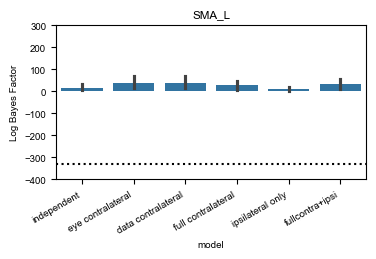

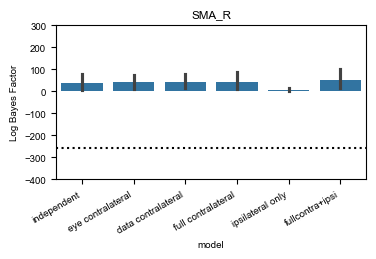

In [ ]:
import pickle

region = 'M1'
hem = ['L', 'R']
plt.rcParams.update({'font.size': 7})
for i, h in enumerate(hem):
    name = f'{region}_{h}'
    # load model fitting:
    with open(os.path.join(analysisDir, f'PCM_bimanual_{name}.pkl'), 'rb') as f:
        results = pickle.load(f)

    T_cv = results['T_cv']
    theta_cv = results['theta_cv']
    fig, ax = plt.subplots(1,1,figsize=(4,2))
    tmp_ax = pcm.model_plot(T_cv.likelihood,
                            null_model = 'null',
                            noise_ceiling= 'ceil')
    # angle the x axis labels:
    plt.xticks(rotation=30, ha='right')
    plt.title(f'{name}')
    ax.set_ylim(-400, 300)
    plt.show()

